# SARIMA Model for Prometheus Anomaly Detection
The final polished implementation of ARIMA (Auto Regression Integrated Moving Average)
and SARIMA (Seasonal Auto Regression Integrated Moving Average) models for time series forecasting of Prometheus metrics.

This notebook contains the following functionalities:

### Data Pre-Processing:
1. Load sample metric data set (Json)
2. Fetch metric timestamp and corresponding metric value from the data set
3. Convert the dataframe into timeseries format
4. Compress the timeseries into (1h/ 0.5h/ 0.25/) frequency

### Data Modelling
1. Train the SARIMA model with the required parameters
2. Forecast the predictions on the test data set
3. Evaluate the predictions for detecting anomalies

In [1]:
import os
import time
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import math

import json as JS
from json import load
from json import loads
from datetime import datetime
#from fbprophet import Prophet

from pmdarima.arima import auto_arima
import statsmodels.api as sm
import mlflow
import mlflow.sklearn
from itertools import product

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pandas as pd
from pandas.io.json import json_normalize
from pandas.plotting import autocorrelation_plot
from pandas.plotting import register_matplotlib_converters

In [2]:
# required package: sklearn
# pip3 install -U scikit-learn scipy matplotlib
# pip3 install statsmodels
# pip3 install pyramid-arima

### Data Pre-Processing

In [3]:
def process_data(data, freq):
    values_col = data["values"]
    new = []
    for x in values_col:
         for y in x:
             y[0] = datetime.fromtimestamp(y[0])
             y[1] = float(y[1])

         new = new + x

    values_col = pd.DataFrame(new)
    values_col.rename(columns = {0: 'Date'}, inplace = True)
    values_col['datetime'] = pd.to_datetime(values_col['Date'])
    values_col= values_col.set_index('datetime')
    values_col.drop(['Date'], axis = 1, inplace = True)
    values_col.rename(columns = {1: 'value'}, inplace = True)
    values_col = values_col.resample(freq).mean()
    values_col = values_col.dropna()      
    return values_col

In [4]:
def split_data(dataframe):
    #Dividing the data set into (80%)training and (20%)testing samples
    dataframe = dataframe.sort_values(by = 'datetime')
    ratio = 0.2
    size = int(len(dataframe) * (1-float(ratio)))
    train, test = dataframe[0:size], dataframe[size:len(dataframe)]
    return train, test

In [5]:
def sarima_driver(dataframe, freq):
    train,test = split_data(dataframe)
    forecast = _sarima(dataframe, train, test, freq)
    # _mlflow_sarima(train,test)
    return forecast, test

### SARIMA Model
Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series. There are three **trend** elements that require configuration. These are the ones that are configured in the standard ARIMA model.

- **p** - Trend autoregression order
- **d** - Trend difference order
- **q** - Trend moving average order

There are four **seasonal** elements that are not part of ARIMA that must be configured; they are:

- **P**: Seasonal autoregressive order.
- **D**: Seasonal difference order.
- **Q**: Seasonal moving average order.
- **m**: The number of time steps for a single seasonal period.


In [6]:
def _sarima(train, test, freq):
    sfrequency = 0
    if freq == '1h':
        sfrequency = 24
    elif freq == '30Min':
        sfrequency = 48
    elif freq == '15Min':
        sfrequency = 96
        
    model = SARIMAX(train, order=(1, 2, 2), seasonal_order=(2,2,2,sfrequency), enforce_stationarity = True, enforce_invertibility = False)
    model_fit = model.fit(dsip=-1)
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    print("Now plotting the residual errors for the SARIMA model")
    plt.show()
    residuals.plot(kind='kde')
    print("Now plotting the desity of the residual error values.")
    plt.show()
    print(residuals.describe())
    K = len(test)

    forecast = model_fit.forecast(K)
    # forecast = np.exp(forecast)
    forecast = pd.DataFrame(forecast.values, columns = ['predict'], index = test.index)

    plt.plot(forecast, label='forecast')
    plt.show()
    plt.figure(figsize=(12,5), dpi=100)
    # plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(forecast, label='forecast')
    # plt.title('RMSE: %.2f'% np.sqrt(sum((forecast-test)**2)/len(test)))
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    return model, model_fit, forecast

In [7]:
def evaluation(forecast, test):
    upper_bound = np.array(
      [
        (
         float(np.ma.average(forecast[:i], axis = 0,weights=np.linspace(0, 1, num=len(forecast[:i]))))
          + (np.std(forecast[:i]) * 2)
        )
        for i in range(len(forecast))
        ]
    )
      # to account for no std of a single value
    lower_bound = np.array(
      [
        (
          float(np.ma.average(
            forecast[:i],axis = 0,
            weights=np.linspace(0, 1, num=len(forecast[:i])),))
          - (np.std(forecast[:i]) * 2)
        )
        for i in range(len(forecast))
        ]
    )

    compare = test.join(forecast, how = 'outer')
    compare = compare.dropna()
    lower = pd.DataFrame(lower_bound, columns = [0], index = test.index)
    upper = pd.DataFrame(upper_bound, columns = [0], index = test.index)

    compare.insert(2, "LowerBound", lower, True)
    compare.insert(3, "UpperBound", upper, True)
    compare['WithinUpperBounds'] = compare['predict'] < compare['UpperBound']
    compare['WithinLowerBounds'] = compare['predict'] > compare['LowerBound']
    
    #Detecting anomalies
    anomaly = []
    for i in range(len(compare)):
        if((compare['value'][i] < compare['UpperBound'][i]) and (compare['value'][i] > compare['LowerBound'][i])):
            anomaly.append(0)
        else:
            anomaly.append(1)
    
    compare.insert(6, "Anomaly", anomaly, True)
    print("The final dataframe with lowerbound, upperbound and prediction value:\n")
    print(compare)

    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(compare['predict'], label='Predicted')
    plt.plot(compare['LowerBound'], label='LowerBound')
    plt.plot(compare['UpperBound'], label='UpperBound')
    plt.plot(compare['value'], label='Actual')
    # plt.title('RMSE: %.2f'% np.sqrt(sum((forecast-test)**2)/len(test)))
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [8]:
data = pd.read_json("metrics/prometheus-route-aiops-prod-prometheus-predict.cloud.paas.psi.redhat.com/badger_disk_writes:rate1m/90 days of data/201910081557.json")
freq = '1h'
processed_data = process_data(data, freq)
train, test = split_data(processed_data)

In [9]:
print(train)

                         value
datetime                      
2019-07-10 15:00:00   0.000000
2019-07-10 16:00:00   0.027417
2019-07-10 17:00:00   7.269352
2019-07-10 18:00:00   4.570231
2019-07-10 19:00:00  11.845331
2019-07-10 20:00:00  82.232372
2019-07-10 21:00:00  21.655741
2019-07-10 22:00:00  16.085827
2019-07-10 23:00:00  13.485695
2019-07-11 00:00:00   0.779119
2019-07-11 01:00:00   0.013334
2019-07-11 02:00:00   0.013802
2019-07-11 03:00:00   0.013385
2019-07-11 04:00:00   0.013333
2019-07-11 05:00:00   0.013490
2019-07-11 06:00:00   0.013281
2019-07-11 07:00:00   0.017251
2019-07-11 08:00:00   0.006918
2019-07-11 09:00:00   0.000500
2019-07-11 10:00:00   0.006000
2019-07-11 11:00:00   0.002010
2019-07-11 12:00:00   0.022636
2019-07-11 13:00:00   0.005958
2019-07-11 14:00:00   0.017750
2019-07-11 15:00:00   0.000500
2019-07-11 16:00:00   0.001167
2019-07-11 17:00:00   0.000000
2019-07-11 18:00:00   0.000000
2019-07-11 19:00:00   0.000000
2019-07-11 20:00:00  53.477574
...     

/home/hemaveeradhi/.local/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Now plotting the residual errors for the SARIMA model


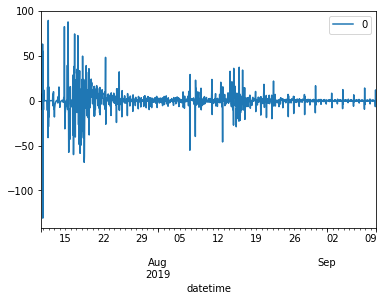

Now plotting the desity of the residual error values.


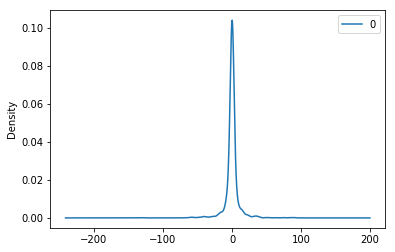

                 0
count  1474.000000
mean      0.109279
std      10.907770
min    -130.947419
25%      -1.162178
50%       0.063802
75%       1.241628
max      89.454181


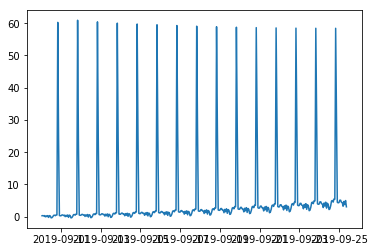

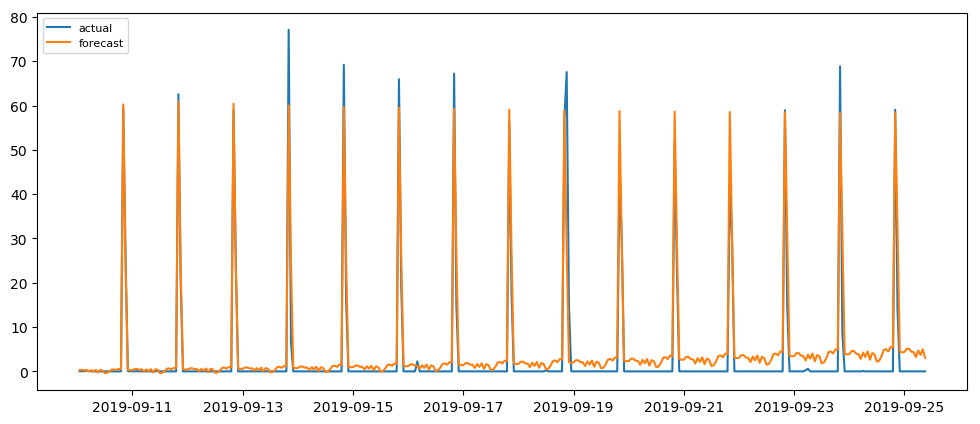

In [10]:
model, model_fit, forecast = _sarima(train, test, freq)

/home/hemaveeradhi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Warning: converting a masked element to nan.
  
/home/hemaveeradhi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.


The final dataframe with lowerbound, upperbound and prediction value:

                         value    predict  LowerBound  UpperBound  \
datetime                                                            
2019-09-10 01:00:00   0.025312   0.280427         NaN         NaN   
2019-09-10 02:00:00   0.027993   0.335040         NaN         NaN   
2019-09-10 03:00:00   0.039052   0.201748    0.280427    0.389653   
2019-09-10 04:00:00   0.122933   0.326883    0.136757    0.355601   
2019-09-10 05:00:00   0.105329  -0.055126    0.180674    0.392388   
2019-09-10 06:00:00   0.009385   0.288073   -0.139009    0.438746   
2019-09-10 07:00:00   0.000000  -0.015771   -0.072924    0.464797   
2019-09-10 08:00:00   0.004242   0.338231   -0.166919    0.437816   
2019-09-10 09:00:00   0.000000  -0.231631   -0.112252    0.484540   
2019-09-10 10:00:00   0.000000   0.330029   -0.302993    0.489603   
2019-09-10 11:00:00   0.000000   0.199630   -0.248424    0.529724   
2019-09-10 12:00:00   0.000000  

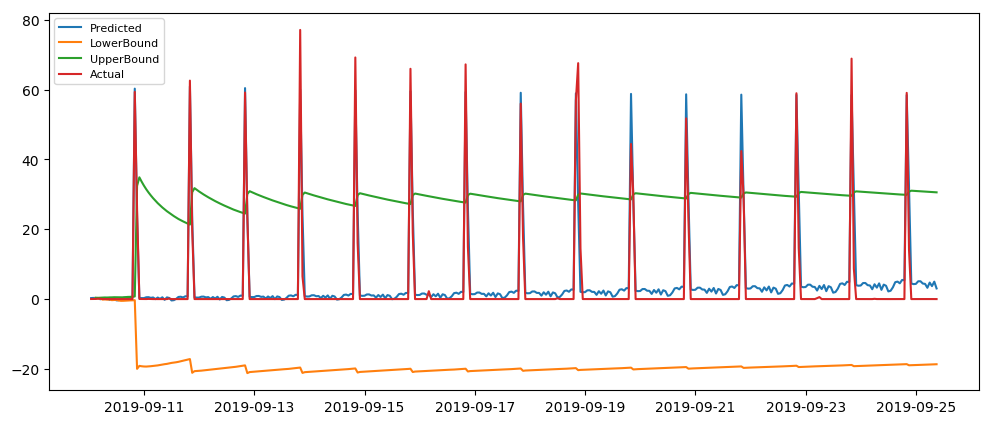

In [11]:
evaluation(forecast, test)